In [1]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma as gf
from scipy.special import hyp1f1 as Mf

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

# Moments: enforcing model structure

When investigating using moment confidence intervals, rather than probabilities, for feasibility tests of interacting models it was found that moment + CME constraints produced identical results to 'dummy' moment factorization constraints:

\begin{align*}
    \sum_{x_{1} = 0}^{max_1} x p_{1}(x) &\in \mathbb{E}[X_{1}] \text{ CI } \quad &\iff \quad y &\in \mathbb{E}[X_{1}] \text{ CI } \\
    \sum_{x_{2} = 0}^{max_2} x p_{2}(x) &\in \mathbb{E}[X_{2}] \text{ CI } &z &\in \mathbb{E}[X_{2}] \text{ CI } \\
    \left(\sum_{x_{1} = 0}^{max_1} x p_{1}(x) \right) \left(\sum_{x_{2} = 0}^{max_2} x p_{2}(x) \right) &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }  &y * z &\in \mathbb{E}[X_{1}X_{2}] \text{ CI }\\

    \textbf{ + CME constraints}
    
\end{align*}

Suggesting that the moment bounds do not constrain probabilities enough for the CME to enforce the model structure e.g. taking non-poisson moments together with a birth-death CME remains feasible.

## Investigation

Use a birth-death model with 1 parameter $k$ and input moments bounds of width $\delta$ about the true value, investigating the resulting bounds on the parameter and probabilities.

Consider the effects of 2nd order moments, capture efficiency, downsampled optimization, etc

# Code

Functions to optimize a birth-death model using moment and CME constraints:

'optimize moment' uses the standard method, using observed moment intervals to bound expressions in terms of the original moments which are set equal to a sum over original probabilities, which are also constrained by the CME.

'optimize moment downsampled' is on the observed scale, using observed moment intervals to directly bound a sum over observed probabilities, which are also constrained by the downsampled CME.

## Settings

- M: size of truncation used for the moment sums $\sum \limits_{x=0}^{M} xp(x)$
- k: birth-death model parameter $k = \frac{k_{tx}}{k_{deg}}$
- a, b: capture efficiency parameters $\beta \sim Beta(a, b)$
- delta: width of input 1st moment bounds about the true value
- deltasq: width of input 2nd moment bounds about the true value
- deltam: width of input $f_{m}$ bounds about the true value (downsampled only)
- gamma: bias added to 2nd moment for non-poisson moments
- var: bool to include the 2nd moment

In [300]:
def optimize_moment(M, k, a, b, delta, deltasq, gamma=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    delta: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [301]:
def fm_numeric(m ,a, b, k):
    '''Numeric computation of f_m = E[Beta|m] for Beta~Beta(a,b) capture.'''

    # terms
    t1 = gf(b + m + a) / gf(m + a)
    t2 = gf(m + a + 1) / gf(b + m + a + 1)
    t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

    # numerical computation of fm
    fm_num = t1 * t2 * t3

    return fm_num

In [302]:
def optimize_moment_downsampled(M, k, a, b, delta, deltasq, gamma=0.0, deltam=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of 1st moment intervals about truth
    deltasq: width of 2nd moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    deltam: width of fm intervals about truth
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (deltasq / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (deltasq / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            fm = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="fm", lb=0, ub=1)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OB)
            expr_EX_OB = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OB = gp.quicksum(p * np.arange(M + 1)**2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # fm intervals
            for m in range(M + 1):
                fm_num = fm_numeric(m, a, b, k)
                model.addConstr(fm[m] <= fm_num + (deltam / 2))
                model.addConstr(fm[m] >= fm_num - (deltam / 2))

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - fm[0] * k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == fm[x - 1] * k_tx * p[x - 1] + (x + 1) * p[x + 1] - (fm[x] * k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

# Parameter Bounds

Investigate bounds on the parameter $k$

## Perfect information

Using $\delta = 0$ we input the exact moment values:

In [206]:
# standard
print("1st Moment:")
solution_s1 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_s2 = optimize_moment(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

1st Moment:
k_tx in (2.0, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (2.0, 2.0), status OPTIMAL, OPTIMAL


And again for downsampled optimization use $\delta = \delta_{m} = 0$:

In [207]:
# downsampled
print("1st Moment:")
solution_d1 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution_d2 = optimize_moment_downsampled(M=100, k=2, a=1, b=20, delta=0.0, deltasq=0.0, silent=True, var=True)

1st Moment:
k_tx in (1.9998567730024175, 100.0), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (1.9999849986008067, 2.000258939999257), status OPTIMAL, OPTIMAL


For both methods:

- 1st moment: exact lower bound, no upper bound
- 1st & 2nd moment: exact lower & upper bounds

This does not depend on capture efficiency, with the results shown above at $\beta \sim Beta(1, 20)$

## Input Interval Width $\delta$

Input moment bounds of width $\delta$, $30 \delta^2$ (*) about true values

(*) see 'Realistic $\delta$ values' section for reasoning

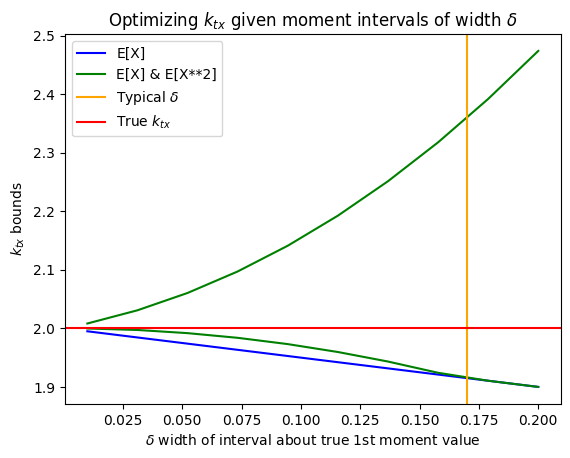

In [212]:
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
b = 0
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
for delta in deltas:
    solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=False)
    solution_moment_var = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
plt.title(r"Optimizing $k_{tx}$ given moment intervals of width $\delta$")
plt.xlabel(r"$\delta$ width of interval about true 1st moment value")
plt.ylabel(r"$k_{tx}$ bounds")
plt.plot(deltas, lbs_moment, color="blue", label="E[X]")
plt.plot(deltas, lbs_moment_var, color="green", label="E[X] & E[X**2]")
# plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, ubs_moment_var, color="green")
plt.axvline(0.17, color="orange", label=r"Typical $\delta$")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

As expected, the width of output bounds on $k_{tx}$ increases with width of input bounds on moments $\delta$: the lower bound scales slightly better with $\delta$, roughly linear for both, while the upper bound starts to accelerate.

For the setting of $k = 2$ and no capture efficiency the average bootstrap interval width is shown in orange, producing a reasonable bound of ~$[1.9, 2.3]$ on the parameter, which suggests there is some enforcement of the model structure for this to be so narrow.

(NOTE: do not show upper bound for E[X] optimization as is just a constant $K = 100$)

(NOTE: do not show downsampled here, as with no capture efficiency is just the same (unless intervals on $f_{m}$ used))

## Capture efficiency $\beta$ Impact

Now consider adding capture efficiency to the input


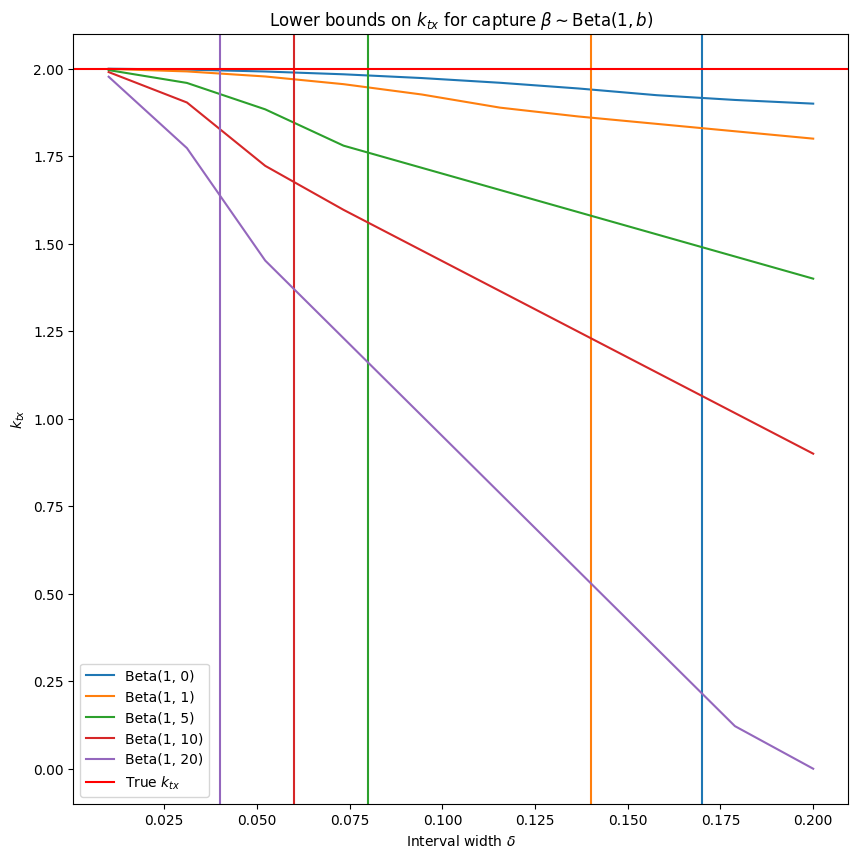

In [221]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"Lower bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

As the capture efficiency decreases, the the lower bound scales worse with $\delta$, but the average width given by the bootstrap in practice also decreases (shown by the vertical lines).

Overall, the lower bound on $k$ at average width decreases with lower capture, reaching ~$1.7$ at $Beta(1, 20)$

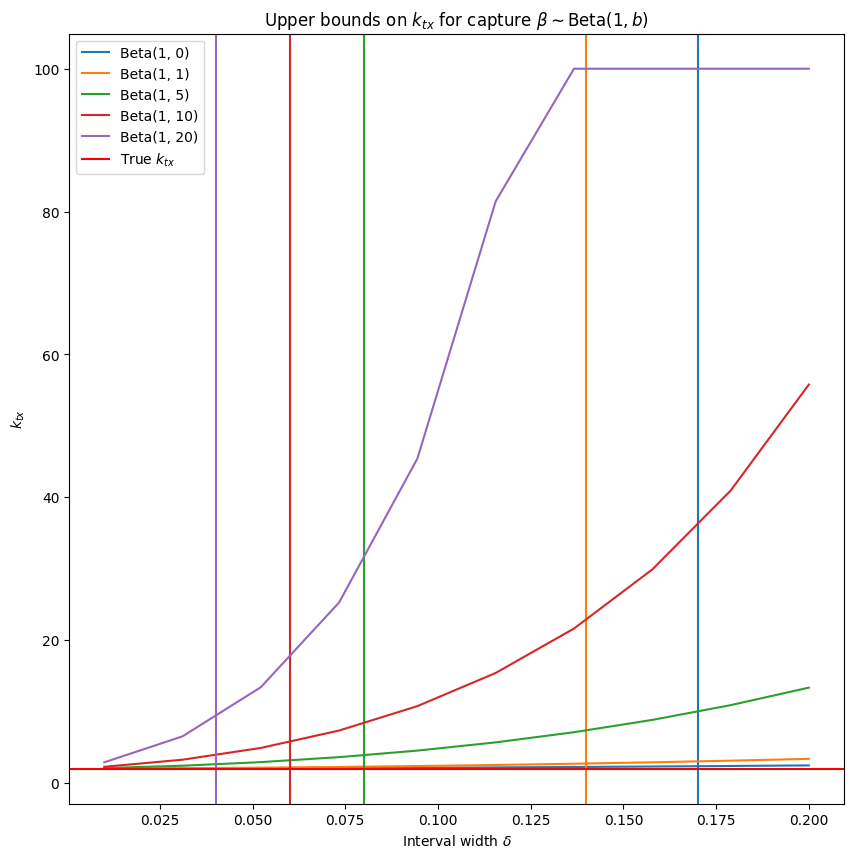

In [222]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 100
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"Upper bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, ubs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

Again as the capture efficiency decreases, the the upper bound scales worse with $\delta$, but the average width given by the bootstrap in practice also decreases (shown by the vertical lines). The scaling is worse than with the lower bound, especially for the lower capture efficiencies whose bounds grow very rapidly.

Overall, the upper bound on $k$ at average width increases with lower capture, reaching ~$10$ at $Beta(1, 20)$

### Downsampled moment constraints

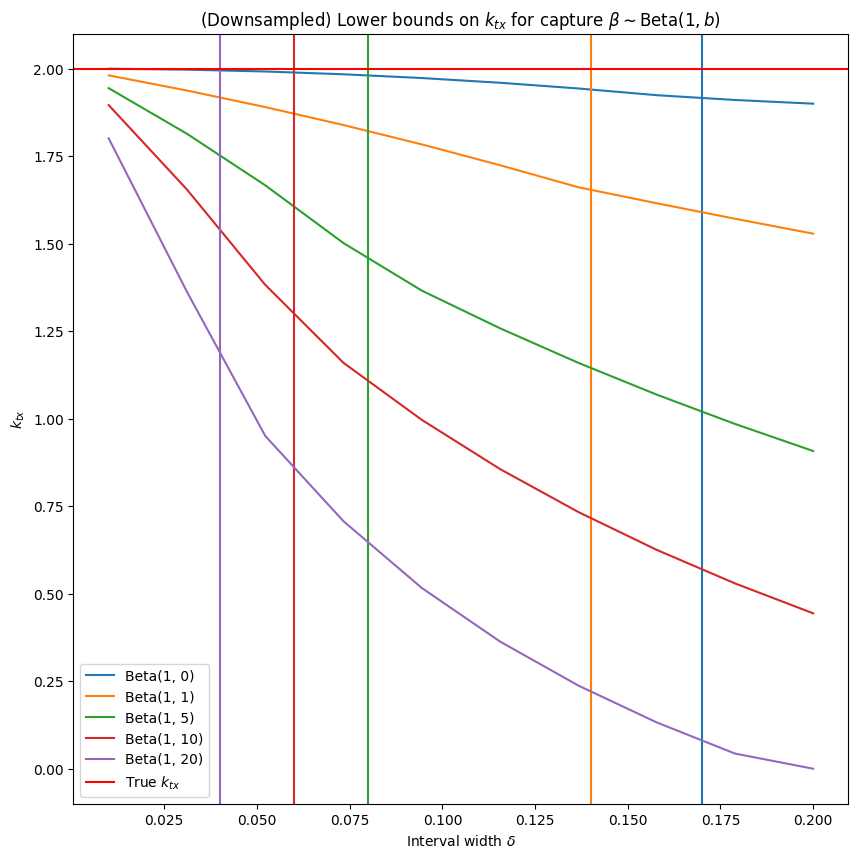

In [293]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Lower bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, lbs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

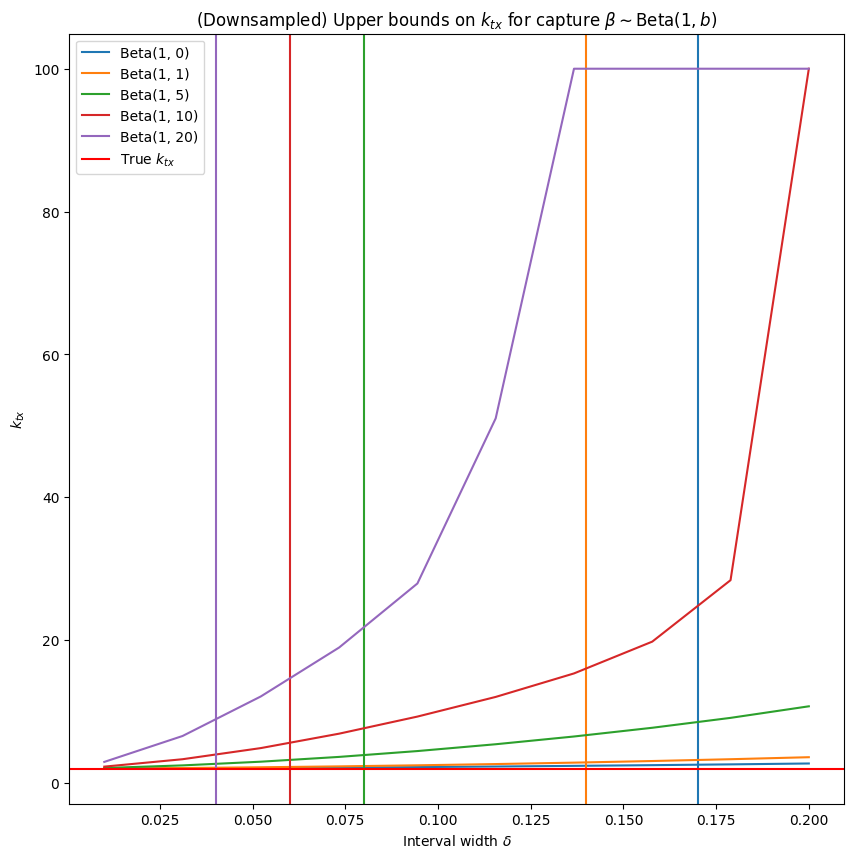

In [295]:
# settings
deltas = np.linspace(0.01, 0.2, 10)
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]
ds = [0.17, 0.14, 0.08, 0.06, 0.04]

# plot
fig, axs = plt.subplots(figsize=(10, 10))
plt.title(r"(Downsampled) Upper bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    axs.plot(deltas, ubs_moment, label=f"Beta(1, {b})", color=f'C{i}')
    axs.axvline(ds[i], color=f'C{i}')
axs.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

Downsampled optimization allows the use of a much smaller number of states (moment sum truncation M down from ~$100$ to ~$10$), but comes at the cost of additional uncertainity in the downsampled rates $f_{m}$. Overall this leads to slightly worse results e.g. lower bound for $Beta(1, 20)$ is ~$1.2$ vs ~$1.7$, but this can be considered a tradeoff for the smaller optimization.

An interval of width $\delta$ (same as 1st moment) about the true $f_{m}$ values was used: the 'Realistic $\delta$ values' shows that this is similar to the average width seen in practice. However, like probabilities the widths vary widely depending on the state, number of occurences in the sample, etc so performance here may be worse than in reality.

## Non-poisson moments

Looking back to using moments to enforce model structure, a main issue was the lack of infeasibility when non-poisson data is used as an input.

To investigate we take the true moment values for a poisson distribution and add a bias of $\gamma$ to the 2nd moment: the resulting mean $\ne$ variance, and the distribution should not satisfy a birth-death CME

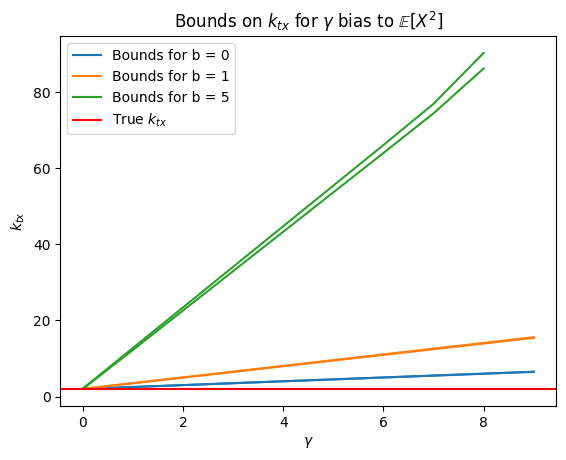

In [307]:
# settings
delta = 0.01
k = 2
M = 100
a = 1
bs = [0, 1, 5]
gammas = [g for g in range(10)]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment(M, k, a, b, delta, 30 * delta**2, gamma, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}", color=f'C{i}')
    plt.plot(gammas, ubs_moment, color=f'C{i}')
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [316]:
solution_moment = optimize_moment(M=100, k=2, a=1, b=0, delta=0.1, deltasq=30 * (0.1**2), gamma=-1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Interestingly, the optimization remains feasible for $\gamma > 0$ and the resulting bounds remain tight (for small $\delta$) but about the wrong values of $k$, as shown by the plot above.

When $\gamma < 0$ the optimization is infeasible (even for roughly average $\delta$) as it should be.

### Downsampled moments

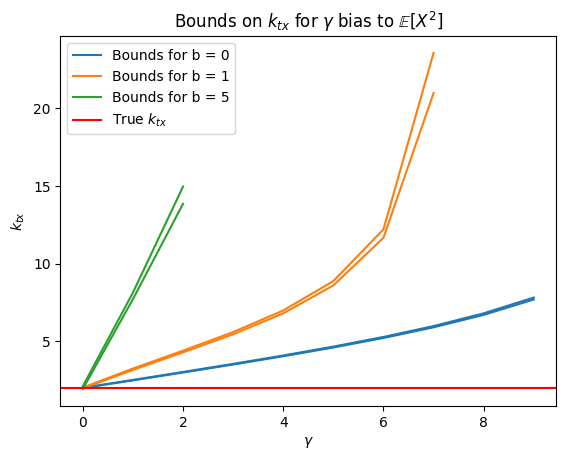

In [313]:
# settings
delta = 0.01
k = 2
M = 10
a = 1
bs = [0, 1, 5]
gammas = [g for g in range(10)]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for i, b in enumerate(bs):
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, 30 * delta**2, gamma, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}", color=f'C{i}')
    plt.plot(gammas, ubs_moment, color=f'C{i}')
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [317]:
solution_moment = optimize_moment_downsampled(M=10, k=2, a=1, b=0, delta=0.1, deltasq=30 * (0.1**2), gamma=-1, deltam=0.1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Largely the same results occur.

## Probability comparison

Briefly use standard: simulated data + bootstrap + probability optimization, to produce bounds on $k$ for the range of capture efficiencies used. Compare reuslts to above moment & moment downsampled results (focusing on reuslts at the typical width lines)

In [3]:
from interaction_inference import constraints, simulation, optimization

In [4]:
def optimize(self, i):
    '''
    Workaround function to re-optimize 'Optimization' object (so attributes filled)
    to minimize and maximize rate, rather than just testing feasibility.
    '''

    # load WLS license credentials
    environment_parameters = json.load(open("../../../WLS_credentials.json"))

    # silence output
    if self.silent:
        environment_parameters['OutputFlag'] = 0
    
    # environment context
    with gp.Env(params=environment_parameters) as env:

        # model context
        with gp.Model('model', env=env) as model:

            # set optimization parameters
            model.Params.TimeLimit = self.time_limit

            # create variables
            variables = constraints.add_variables(self, model, i)

            # add constraints
            constraints.add_constraints(self, model, variables, i)
            
            # optimize
            solution = {}
            model.setObjective(variables['k_tx_1'], GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(variables['k_tx_1'], GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [5]:
rng = np.random.default_rng()

In [7]:
# settings
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]

# solutions
prob_lbs = []
prob_ubs = []

# simulate data
data = simulation.simulate_dataset_range_BD("test", [0], rate=k)

# capture
for i, b in enumerate(bs):

    # simulate capture
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)

    # downsampled data
    dataset = data.downsample("test", beta)
    dataset.compute_probabilities()

    # optimize (feasibility, just to get attributes sorted)
    opt = optimization.Optimization(
        dataset,
        [
            "marginal_probability_1",
            "marginal_CME_1",
            "k_deg_1"
        ],
        license_file="../../../WLS_credentials.json",
        print_solution=False,
        tqdm_disable=True,
        time_limit=1
    )

    # reset time limit
    opt.time_limit = 300

    # re-optimize (bound k_tx)
    sol = optimize(opt, 0)

    prob_lbs.append(sol['min'])
    prob_ubs.append(sol['max'])

k_tx in (1.9042329424675306, 2.1125453868221173), status OPTIMAL, OPTIMAL


MemoryError: Unable to allocate 11.4 GiB for an array with shape (36883, 41639) and data type float64

In [338]:
# settings
k = 2
M = 10
a = 1
bs = [0, 1, 5, 10, 20]

# solutions
prob_lbs = []
prob_ubs = []

# simulate data
data = simulation.simulate_dataset_range_BD("test", [0], rate=k)

# capture
for i, b in enumerate(bs):

    # simulate capture
    if b == 0:
        beta = np.ones(1000)
    else:
        beta = rng.beta(1, b, size=1000)

    # downsampled data
    dataset = data.downsample("test", beta)
    dataset.bootstrap_marginal_probabilities()
    dataset.bootstrap_marginal_fm()

    # optimize (feasibility)
    opt = optimization.Optimization(
        dataset,
        [
            "downsampled_marginal_probability_1",
            "downsampled_marginal_CME_1",
            "k_deg_1"
        ],
        license_file="../../../WLS_credentials.json",
        print_solution=False,
        tqdm_disable=True
    )

    # re-optimize (bound k_tx)
    sol = optimize(opt, 0)

    prob_lbs.append(sol['min'])
    prob_ubs.append(sol['max'])

k_tx in (2.0751392329239504, 2.1190627555436246), status OPTIMAL, OPTIMAL
k_tx in (1.8581692210712197, 2.4726718710502578), status OPTIMAL, OPTIMAL
k_tx in (1.8442306306378198, 2.223908655216985), status OPTIMAL, OPTIMAL
k_tx in (1.8688304219119005, 2.4938605221344545), status OPTIMAL, OPTIMAL
k_tx in (1.5065186518070022, 2.611011603104314), status OPTIMAL, OPTIMAL


# Old

## Impact of non-poisson data

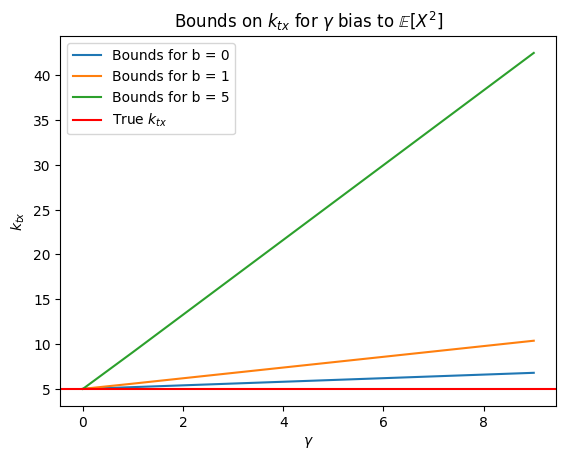

In [293]:
# settings
delta = 0.01
gammas = [g for g in range(10)]
k = 5
m = 100
a = 1
bs = [0, 1, 5]

# plot
plt.title(r"Bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment(M, k, a, b, delta, gamma, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

In [295]:
solution_moment = optimize_moment(20, 5, 1, 0, 0.01, -1, printing=True, silent=True, time_limit=60, var=True)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


Infeasible when 2nd moment smaller than 1st moment, but when 2nd moment larger the optimization is still feasible but the resulting bounds do not contain the true parameter value

## Comparison to probabilities

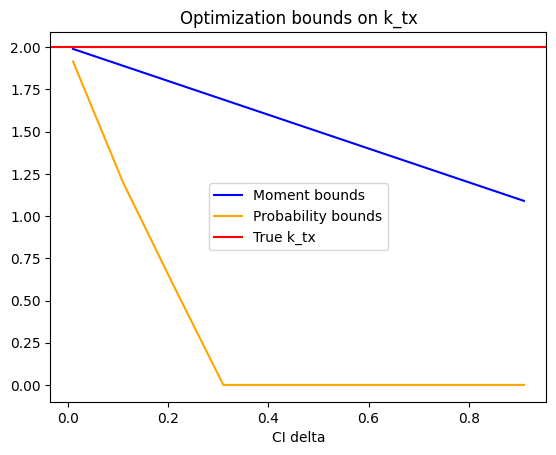

In [190]:
deltas = [0.01 + d/10 for d in range(10)]
k = 2
m = 20
lbs_moment = []
ubs_moment = []
lbs_probs = []
ubs_probs = []
for delta in deltas:
    solution_moment = optimize_moment(m, k, delta, silent=True, printing=False, var=False)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    solution_probs = optimize_probability(m, k, delta, silent=True, printing=False)
    lbs_probs.append(solution_probs['min'])
    ubs_probs.append(solution_probs['max'])
plt.title("Optimization bounds on k_tx")
plt.xlabel("CI delta")
plt.plot(deltas, lbs_moment, color="blue", label="Moment bounds")
#plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, lbs_probs, color="orange", label="Probability bounds")
#plt.plot(deltas, ubs_probs, color="orange")
plt.axhline(k, color="red", label="True k_tx")
plt.legend()

BUT unfair comparison? as confidence interval width will be related to value, and moments are typically larger values than probabilities (which are in [0, 1] and often small)

Need to find typical ranges of CI width to assess

## Old code

In [ ]:
def optimize_moment_old(M, k, delta, silent=True, printing=True, time_limit=300, var=False):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            E_x = model.addVar(vtype=GRB.CONTINUOUS, name="E_x")
            if var: E_x_2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x_2")

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # moments
            expr_E_x = gp.quicksum(p * np.arange(M + 1))
            if var: expr_E_x_2 = gp.quicksum(p * np.arange(M + 1)**2)

            model.addConstr(E_x == expr_E_x, name="E_x_equality")
            if var: model.addConstr(E_x_2 == expr_E_x_2, name="E_x_2_equality")

            model.addConstr(E_x <= k + delta, name="E_x_UB")
            model.addConstr(E_x >= k - delta, name="E_x_LB")
            
            if var: model.addConstr(E_x_2 <= k + k**2 + delta, name="E_x_2_UB")
            if var: model.addConstr(E_x_2 >= k + k**2 - delta, name="E_x_2_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [ ]:
def optimize_probability(M, k, delta, silent=True, printing=True, time_limit=300):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # constraints

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probabilities
            probs = scipy.stats.poisson.pmf(np.arange(M + 1), k)
            model.addConstr(p <= probs + delta, name="p_UB")
            model.addConstr(p >= probs - delta, name="p_LB")

            # CME
            model.addConstr(
                0 == p[1] - k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]
            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

## $f_{m}$ computation test

In [334]:
# generator
rng = np.random.default_rng(319)

# settings
m = 10
k = 1
a = 1
b = 2
n = 100000

# large sample of capture efficiencies
beta = rng.beta(a, b, size=n)

# estimated fm
expr = beta**m * np.exp(-beta * k)
fm_est = np.sum(beta * expr) / np.sum(expr)

print(f"f_{m} = {float(fm_est)}")

f_10 = 0.8358749235171602


In [ ]:
from scipy.special import gamma as gf
from scipy.special import factorial as fac
from scipy.special import hyp1f1 as Mf

# terms
t1 = gf(b + m + a) / gf(m + a)
t2 = gf(m + a + 1) / gf(b + m + a + 1)
t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

# numerical computation of fm
fm_num = t1 * t2 * t3

print(f"f_{m} = {float(fm_num)}")

f_10 = 0.8364130861373231


## Downsampled moment optimization

In [350]:
def fm_numeric(m ,a, b, k):
    '''Numeric computation of f_m = E[Beta|m] for Beta~Beta(a,b) capture.'''

    # terms
    t1 = gf(b + m + a) / gf(m + a)
    t2 = gf(m + a + 1) / gf(b + m + a + 1)
    t3 = Mf(m + a + 1, b + m + a + 1, -k) / Mf(m + a, b + m + a, -k)

    # numerical computation of fm
    fm_num = t1 * t2 * t3

    return fm_num

In [353]:
def optimize_moment_downsampled(M, k, a, b, delta, gamma=0.0, deltam=0.0, silent=True, printing=True, time_limit=300, var=False):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (delta / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (delta / 2)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)
            fm = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="fm", lb=0, ub=1)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OB)
            expr_EX_OB = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OB = gp.quicksum(p * np.arange(M + 1)**2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # fm intervals
            for m in range(M + 1):
                fm_num = fm_numeric(m, a, b, k)
                model.addConstr(fm[m] <= fm_num + (deltam / 2))
                model.addConstr(fm[m] >= fm_num - (deltam / 2))

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - fm[0] * k_tx * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == fm[x - 1] * k_tx * p[x - 1] + (x + 1) * p[x + 1] - (fm[x] * k_tx + x) * p[x] for x in range(1, M)
                ),
                name="CME_x1_x2"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt-dsp.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

    return solution

In [357]:
print("1st Moment:")
solution = optimize_moment_downsampled(M=20, k=2, a=1, b=20, delta=0.0, silent=True, var=False)
print("1st and 2nd Moments:")
solution = optimize_moment_downsampled(M=20, k=2, a=1, b=20, delta=0.0, silent=True, var=True)

1st Moment:
k_tx in (1.9999997544866872, 99.99999983547221), status OPTIMAL, OPTIMAL
1st and 2nd Moments:
k_tx in (1.9999928987252316, 2.0003080848901305), status OPTIMAL, OPTIMAL


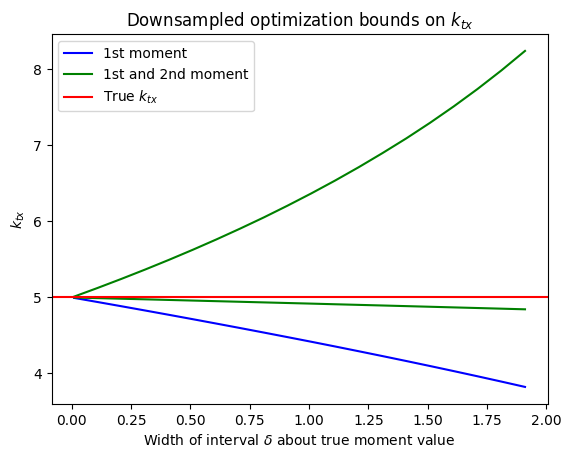

In [358]:
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 20
a = 1
b = 1
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
for delta in deltas:
    solution_moment = optimize_moment_downsampled(M, k, a, b, delta, printing=False, var=False)
    solution_moment_var = optimize_moment_downsampled(M, k, a, b, delta, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
plt.title(r"Downsampled optimization bounds on $k_{tx}$")
plt.xlabel(r"Width of interval $\delta$ about true moment value")
plt.ylabel(r"$k_{tx}$")
plt.plot(deltas, lbs_moment, color="blue", label="1st moment")
plt.plot(deltas, lbs_moment_var, color="green", label="1st and 2nd moment")
# plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, ubs_moment_var, color="green")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

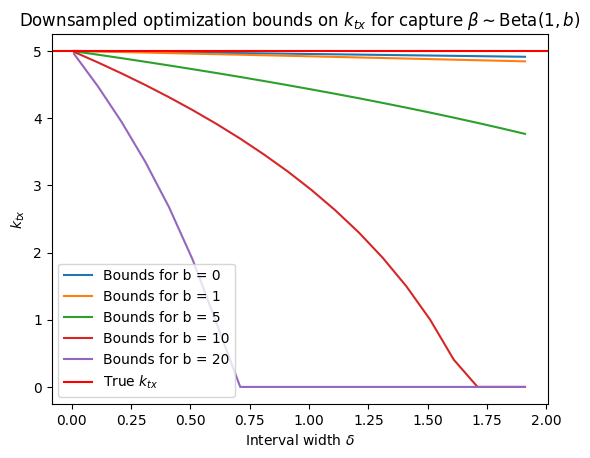

In [ ]:
# settings
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]

# plot
plt.title(r"Downsampled optimization bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

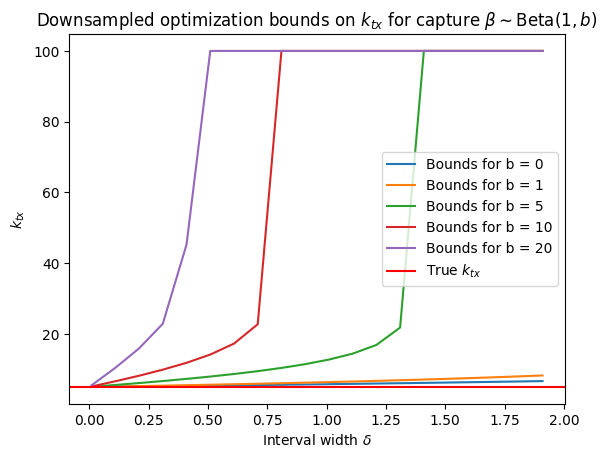

In [346]:
# settings
deltas = [0.01 + d/10 for d in range(20)]
k = 5
M = 20
a = 1
bs = [0, 1, 5, 10, 20]

# plot
plt.title(r"Downsampled optimization bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, ubs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

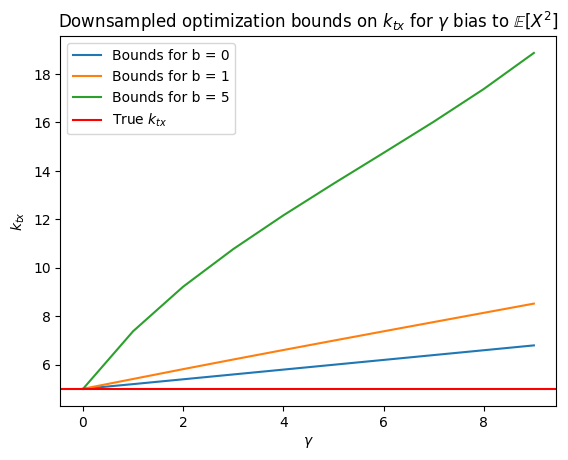

In [348]:
# settings
delta = 0.01
gammas = [g for g in range(10)]
k = 5
m = 20
a = 1
bs = [0, 1, 5]

# plot
plt.title(r"Downsampled optimization bounds on $k_{tx}$ for $\gamma$ bias to $\mathbb{E}[X^{2}]$")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for gamma in gammas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, gamma, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(gammas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

## $f_{m}$ intervals

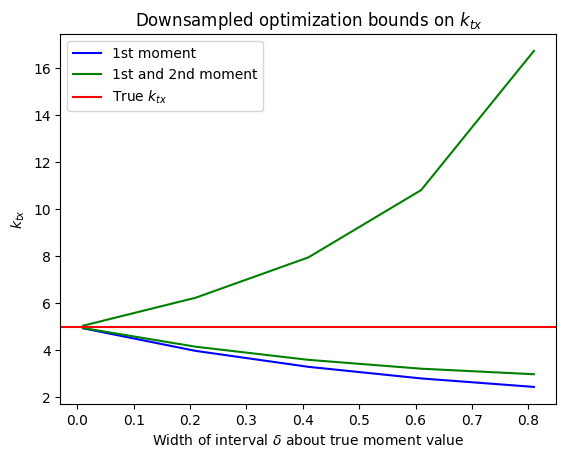

In [361]:
deltas = [0.01 + d/5 for d in range(5)]
k = 5
M = 20
a = 1
b = 1
lbs_moment = []
ubs_moment = []
lbs_moment_var = []
ubs_moment_var = []
for delta in deltas:
    solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltam=delta, printing=False, var=False)
    solution_moment_var = optimize_moment_downsampled(M, k, a, b, delta, deltam=delta, printing=False, var=True)
    lbs_moment.append(solution_moment['min'])
    ubs_moment.append(solution_moment['max'])
    lbs_moment_var.append(solution_moment_var['min'])
    ubs_moment_var.append(solution_moment_var['max'])
plt.title(r"Downsampled optimization bounds on $k_{tx}$")
plt.xlabel(r"Width of interval $\delta$ about true moment value")
plt.ylabel(r"$k_{tx}$")
plt.plot(deltas, lbs_moment, color="blue", label="1st moment")
plt.plot(deltas, lbs_moment_var, color="green", label="1st and 2nd moment")
# plt.plot(deltas, ubs_moment, color="blue")
plt.plot(deltas, ubs_moment_var, color="green")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

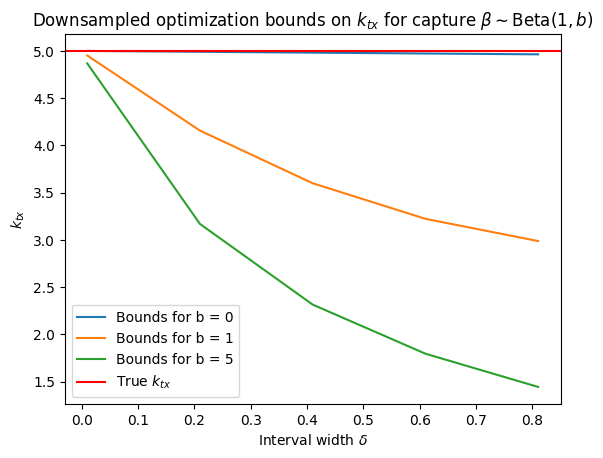

In [360]:
# settings
deltas = [0.01 + d/5 for d in range(5)]
k = 5
M = 20
a = 1
bs = [0, 1, 5]#, 10, 20]

# plot
plt.title(r"Downsampled optimization bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, lbs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

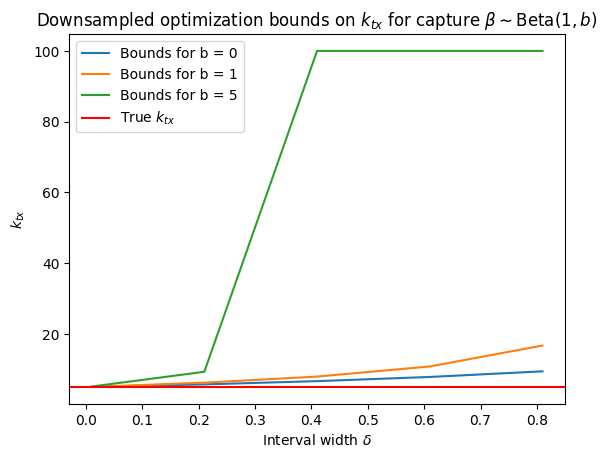

In [362]:
# settings
deltas = [0.01 + d/5 for d in range(5)]
k = 5
M = 20
a = 1
bs = [0, 1, 5]#, 10, 20]

# plot
plt.title(r"Downsampled optimization bounds on $k_{tx}$ for capture $\beta \sim \text{Beta}(1, b)$")
plt.xlabel(r"Interval width $\delta$")
plt.ylabel(r"$k_{tx}$")

# run
for b in bs:
    lbs_moment = []
    ubs_moment = []
    for delta in deltas:
        solution_moment = optimize_moment_downsampled(M, k, a, b, delta, deltam=delta, printing=False, var=True)
        lbs_moment.append(solution_moment['min'])
        ubs_moment.append(solution_moment['max'])
    plt.plot(deltas, ubs_moment, label=f"Bounds for b = {b}")
plt.axhline(k, color="red", label=r"True $k_{tx}$")
plt.legend()

# Distribution bounds

Bounds of p(x) as delta increases

In [68]:
def optimize_moment_p(M, k, a, b, delta, gamma=0.0, silent=True, printing=True, time_limit=300, var=False, CME=True):
    '''
    M: size of moment sum
    k: true k_tx value (assumed k_deg = 1)
    a: Beta(a, b) capture
    b: Beta(a, b) capture
    delta: width of moment intervals about truth
    gamma: bias added to 2nd moment (but not 1st)
    silent: toggle optimization log
    printing: toggle status printing
    time_limt: optimization time limit
    var: toggle use of 2nd moment
    '''

    # Capture efficiency moments
    Ebeta = a / (a + b) 
    Ebeta2 = (a * (a + 1)) / ((a + b + 1) * (a + b))

    # constructed moment intervals (gamma bias to 2nd moment)
    EX_OB_LB = (k * Ebeta) - (delta / 2)
    EX_OB_UB = (k * Ebeta) + (delta / 2)
    EX2_OB_LB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma - (delta / 2)
    EX2_OB_UB = (k + k**2)*Ebeta2 + k*(Ebeta - Ebeta2) + gamma + (delta / 2)
    
    # WLS license
    options = {}# json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=M + 1, vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # base
            model.addConstr(p.sum() <= 1, name="Distribution")

            # expression for moments (OG)
            expr_EX_OG = gp.quicksum(p * np.arange(M + 1))
            if var:
                expr_EX2_OG = gp.quicksum(p * np.arange(M + 1)**2)

            # expressions for moments (OB)
            expr_EX_OB = expr_EX_OG * Ebeta
            if var:
                expr_EX2_OB = expr_EX2_OG*Ebeta2 + expr_EX_OG*(Ebeta - Ebeta2)

            # moment bounds (OB CI)
            model.addConstr(expr_EX_OB <= EX_OB_UB, name="EX_UB")
            model.addConstr(expr_EX_OB >= EX_OB_LB, name="EX_LB")
            if var:
                model.addConstr(expr_EX2_OB <= EX2_OB_UB, name="EX2_UB")
                model.addConstr(expr_EX2_OB >= EX2_OB_LB, name="EX2_LB")

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, M)
                    ),
                    name="CME_x1_x2"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            p_bounds = np.zeros((M + 1, 2))
            for x in range(M + 1):
                model.setObjective(p[x], GRB.MAXIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 1] = model.ObjVal
                except:
                    p_bounds[x, 1] = -1

                model.setObjective(p[x], GRB.MINIMIZE)
                model.optimize()
                try:
                    p_bounds[x, 0] = model.ObjVal
                except:
                    p_bounds[x, 0] = -1

            # store
            solution['p'] = p_bounds

    return solution

In [59]:
from interaction_inference import simulation
rng = np.random.default_rng()

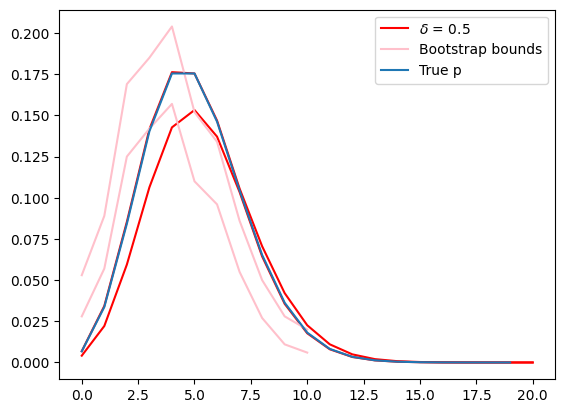

In [67]:
deltas = [0.5] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["red", "blue", "green", "orange", "black"]

for i, delta in enumerate(deltas):
    solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True)
    plt.plot(solution_moment_var['p'][:, 0], color=colours[i], label=r"$\delta$ = " + str(delta))
    plt.plot(solution_moment_var['p'][:, 1], color=colours[i])

data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=5)
#beta = rng.beta(a, b, size=1000)
data_downsampled = data# data.downsample("test", beta)
data_downsampled.bootstrap_marginal_probabilities()

lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

plt.plot(lb, color="pink", label="Bootstrap bounds")
plt.plot(ub, color="pink")

plt.plot(scipy.stats.poisson.pmf(range(20), k), label="True p")

plt.legend()

## Constraints on p(x) very wide given just moment intervals

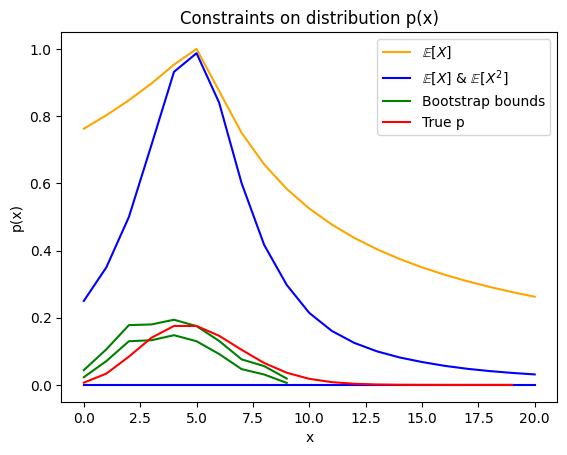

In [86]:
deltas = [0.25] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["orange", "blue", "green", "orange", "black"]

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=False, CME=False)
plt.plot(solution_moment_var['p'][:, 0], color=colours[0], label=r"$\mathbb{E}[X]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[0])

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True, CME=False)
plt.plot(solution_moment_var['p'][:, 0], color=colours[1], label=r"$\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[1])

data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
#beta = rng.beta(a, b, size=1000)
data_downsampled = data# data.downsample("test", beta)
data_downsampled.bootstrap_marginal_probabilities()

lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

plt.plot(lb, color="green", label="Bootstrap bounds")
plt.plot(ub, color="green")

plt.plot(scipy.stats.poisson.pmf(range(20), k), color="red", label="True p")

plt.title("Constraints on distribution p(x)")
plt.xlabel("x")
plt.ylabel("p(x)")

plt.legend()

## Poisson distribution still feasible given non-poisson moment intervals

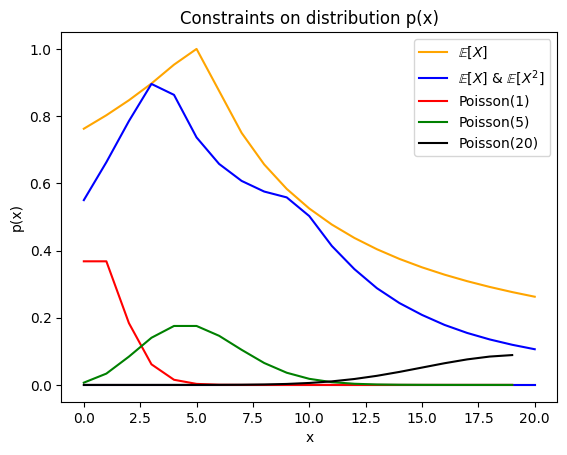

In [85]:
deltas = [0.25] # [0.01 + d/10 for d in range(3)]
k = 5
M = 20
a = 1
b = 0

colours = ["orange", "blue", "green", "orange", "black"]

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=False, CME=False, gamma=1)
plt.plot(solution_moment_var['p'][:, 0], color=colours[0], label=r"$\mathbb{E}[X]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[0])

solution_moment_var = optimize_moment_p(M, k, a, b, delta, printing=False, var=True, CME=False, gamma=20)
plt.plot(solution_moment_var['p'][:, 0], color=colours[1], label=r"$\mathbb{E}[X]$ & $\mathbb{E}[X^{2}]$")
plt.plot(solution_moment_var['p'][:, 1], color=colours[1])

#data = simulation.simulate_dataset_range_BD("test", interaction_values=[0], cells=1000, rate=k)
#beta = rng.beta(a, b, size=1000)
#data_downsampled = data# data.downsample("test", beta)
#data_downsampled.bootstrap_marginal_probabilities()

#lb = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][0, :] if x > 0]
#ub = [x for x in data_downsampled.probs_OB['sample-0']['x1_bounds'][1, :] if x < 1]

#plt.plot(lb, color="green", label="Bootstrap bounds")
#plt.plot(ub, color="green")


plt.plot(scipy.stats.poisson.pmf(range(20), 1), color="red", label="Poisson(1)")
plt.plot(scipy.stats.poisson.pmf(range(20), 5), color="green", label="Poisson(5)")
plt.plot(scipy.stats.poisson.pmf(range(20), 20), color="black", label="Poisson(20)")

plt.title("Constraints on distribution p(x)")
plt.xlabel("x")
plt.ylabel("p(x)")

plt.legend()

## Moment + Model constraints

\begin{align}
    \mathbb{E}[X] &\in CI &\mathbb{E}[X^{2}] &\in CI \\
    \mathbb{E}[X] &= \sum \limits_{x = 0}^{T} x p(x) &\mathbb{E}[X^{2}] &= \sum \limits_{x = 0}^{T} x^{2} p(x) \\
    &&Q^{BD}p = 0
\end{align}

# Realistic $\delta$ values

Simulate data from birth-death model and bootstrap moments to get typical widths of intervals

In [98]:
from interaction_inference import simulation

In [99]:
rng = np.random.default_rng()

In [ ]:
delta_dict = {}
for k in [1, 2, 5]:
    dataset = simulation.simulate_dataset_range_BD("test", [0 for j in range(5)], rate=k, tqdm_disable=False)
    for b in [0, 1, 5, 10, 20]:
        if b == 0:
            beta = np.ones(1000)
        else:
            beta = rng.beta(1, b, size=1000)
        dataset_downsampled = dataset.downsample("test", beta)
        dataset_downsampled.compute_moments(tqdm_disable=False)

        deltas = []
        deltas_sq = []
        for sample, moments in dataset_downsampled.moments_OB.items():
            d1 = moments['E_x1'][1] - moments['E_x1'][0]
            d2 = moments['E_x2'][1] - moments['E_x2'][0]
            ds1 = moments['E_x1_sq'][1] - moments['E_x1_sq'][0]
            ds2 = moments['E_x2_sq'][1] - moments['E_x2_sq'][0]

            deltas.append(d1)
            deltas.append(d2)
    
            deltas_sq.append(ds1)
            deltas_sq.append(ds2)

        delta_dict[(k, b)] = {
            'deltas': deltas,
            'deltas_sq': deltas_sq
        }

100%|██████████| 5/5 [00:00<00:00, 26.25it/s]


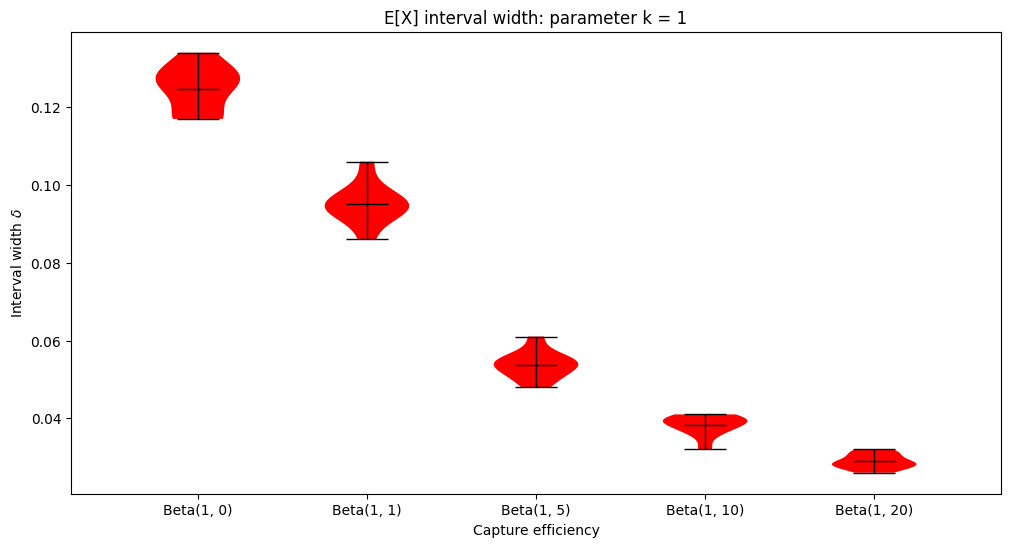

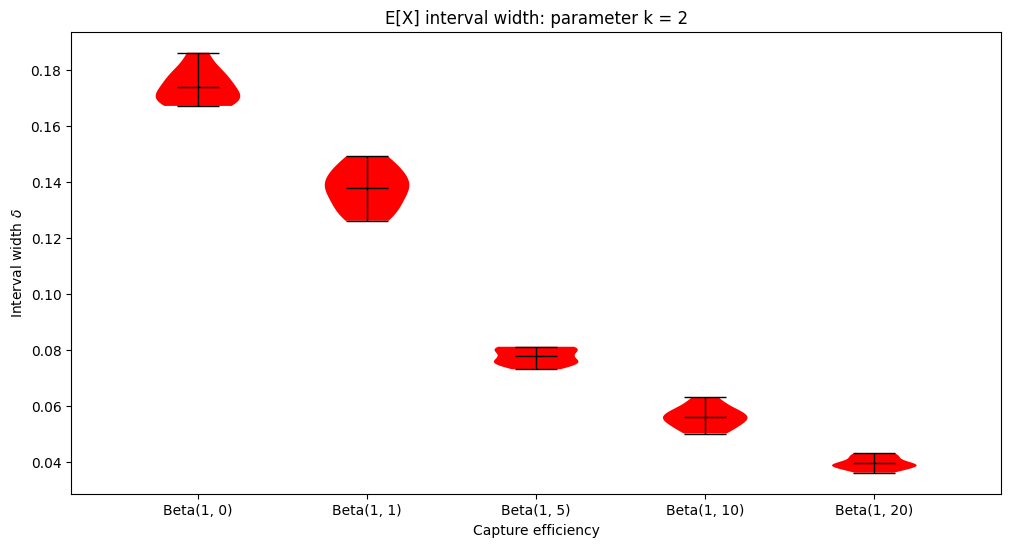

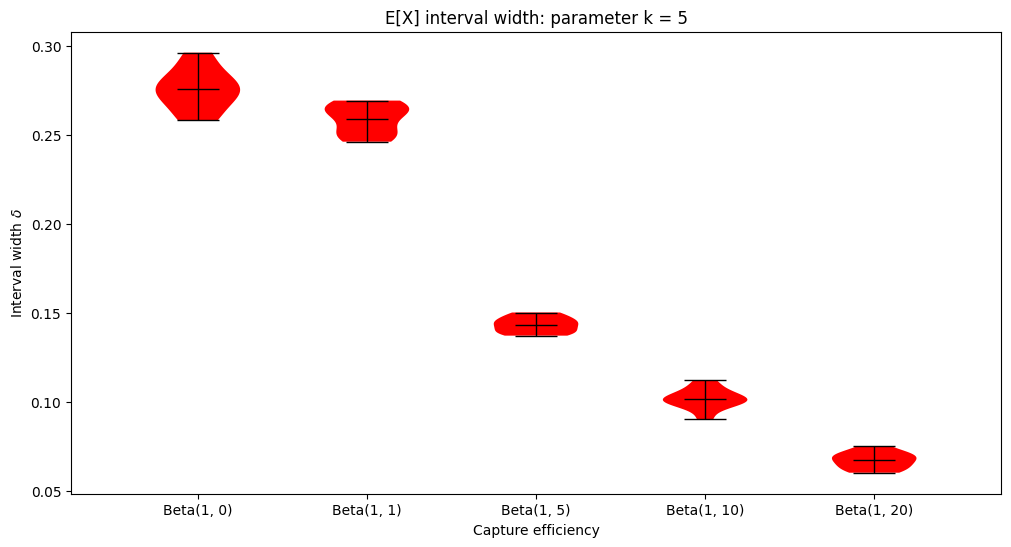

In [159]:
for k in [1, 2, 5]:

    delta_plot = [[float(x) for x in delta_dict[(k, b)]['deltas']] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        delta_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'E[X] interval width: parameter k = {k}')

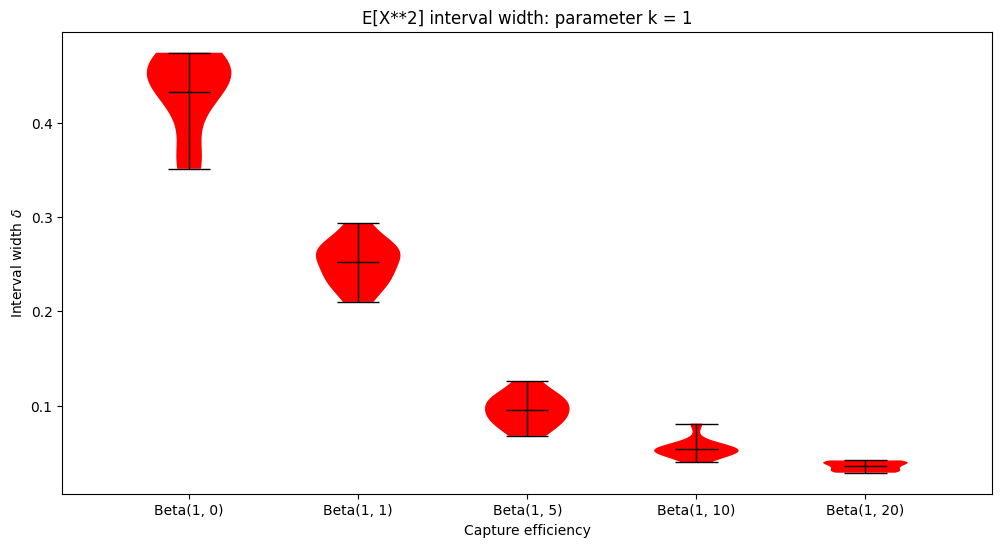

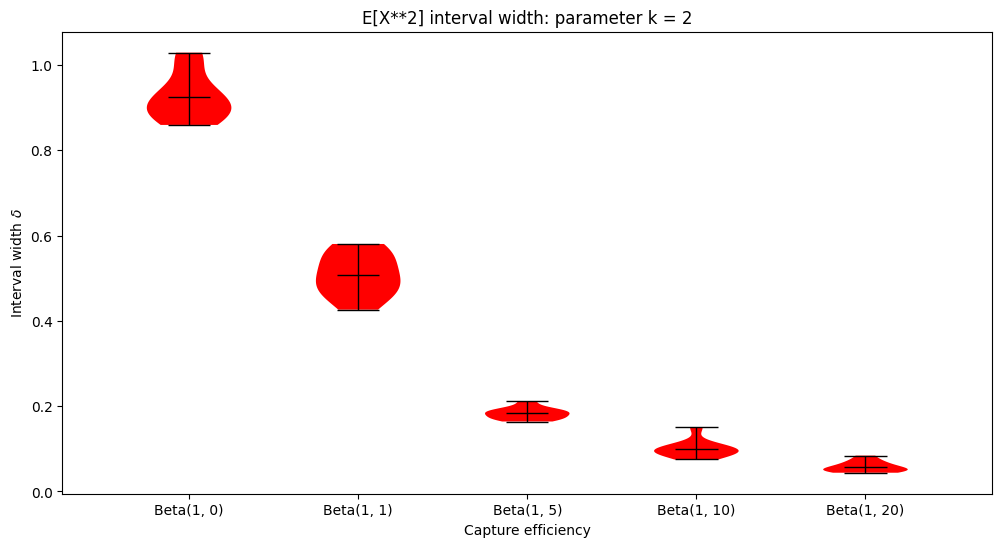

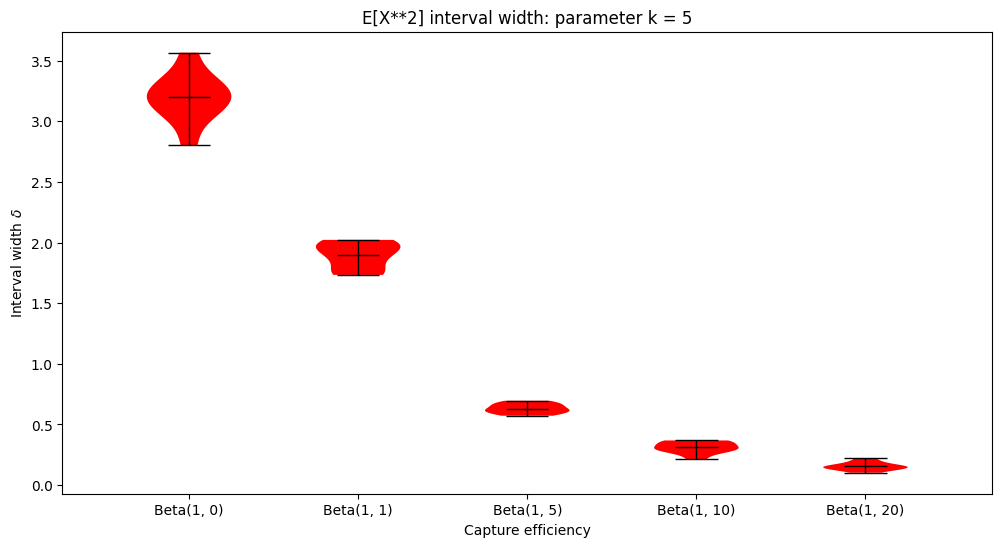

In [160]:
for k in [1, 2, 5]:

    delta_plot = [[float(x) for x in delta_dict[(k, b)]['deltas_sq']] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        delta_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'E[X**2] interval width: parameter k = {k}')

Text(0, 0.5, 'Width')

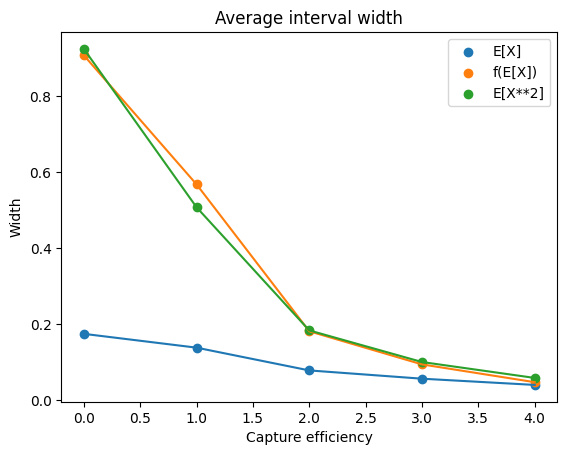

In [198]:
k = 2
dmeans = []
dsqmeans = []
for b in [0, 1, 5, 10, 20]:
    deltas = delta_dict[(k, b)]['deltas']
    deltas_sq = delta_dict[(k, b)]['deltas_sq']
    
    dmeans.append(np.mean(deltas))
    dsqmeans.append(np.mean(deltas_sq))

adj = [30 * x**2 for x in dmeans]

plt.plot(dmeans)
plt.scatter(range(5), dmeans, label="E[X]")
plt.plot(adj)
plt.scatter(range(5), adj, label="f(E[X])")
plt.plot(dsqmeans)
plt.scatter(range(5), dsqmeans, label="E[X**2]")
plt.legend()
plt.title("Average interval width")
plt.xlabel("Capture efficiency")
plt.ylabel("Width")

In [201]:
# deltas
dmeans

[np.float64(0.17393),
 np.float64(0.13754999999999998),
 np.float64(0.07761),
 np.float64(0.05581499999999999),
 np.float64(0.03941)]

## 1st vs 2nd moment widths

Want to input bounds about 1st and 2nd moments, but see from the plot above that the average width of bootstrap intervals is very different for the two moments.

A function of $f(x) = 30 x^2$ mapping the width of the 1st moment interval to the width of the 2nd seems to map well across a range of capture efficiencies, so can use $\delta$ and $30 \delta^2$ as respective widths about true values for testing.

Also see that the range of $\delta$ seen is around $[0, 0.2]$, so focus on a range similar to this.

(NOTE: relationship differs for different parameters, choose to focus on k = 2)


## $f_{m}$ widths

In [234]:
fm_dict = {}
for k in [1, 2, 5]:
    dataset = simulation.simulate_dataset_range_BD("test", [0 for j in range(5)], rate=k, tqdm_disable=False)
    for b in [0, 1, 5, 10, 20]:
        if b == 0:
            beta = np.ones(1000)
        else:
            beta = rng.beta(1, b, size=1000)
        dataset_downsampled = dataset.downsample("test", beta)
        dataset_downsampled.bootstrap_marginal_fm(tqdm_disable=False)

        fms = []
        for sample, moments in dataset_downsampled.fm_OB.items():
            f1 = moments['fm1'][1] - moments['fm1'][0]
            f2 = moments['fm2'][1] - moments['fm2'][0]

            fms = fms + list(f1)
            fms = fms + list(f2)

        fm_dict[(k, b)] = fms

100%|██████████| 5/5 [00:00<00:00, 52.73it/s]


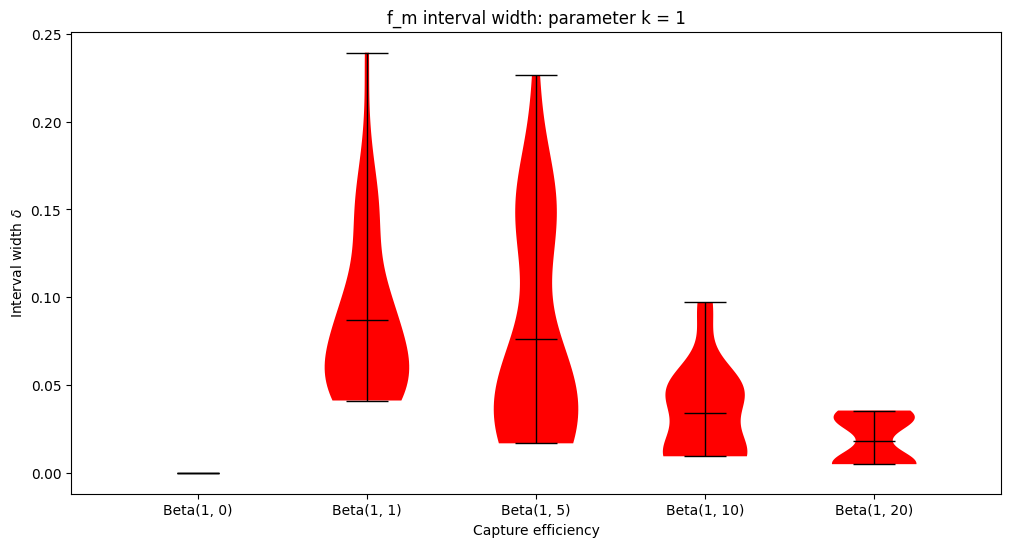

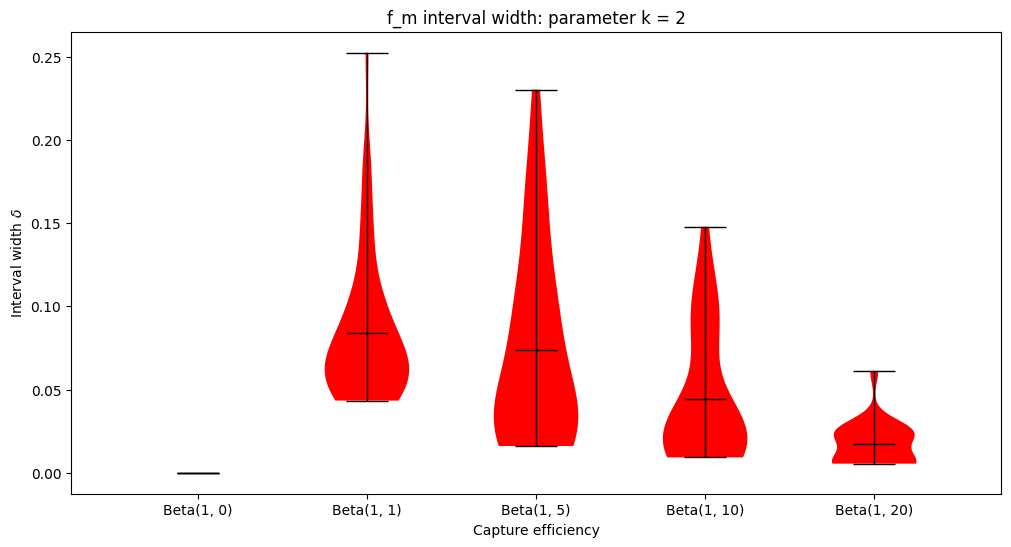

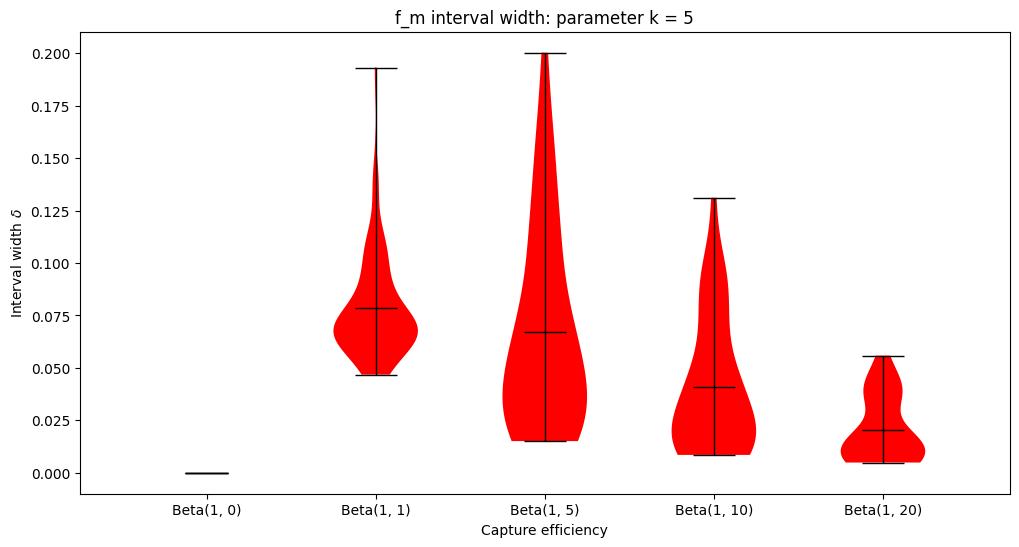

In [240]:
for k in [1, 2, 5]:

    # remove widths = 1
    fm_plot = [[float(x) for x in fm_dict[(k, b)] if not (x == 1)] for b in [0, 1, 5, 10, 20]]

    fig, axs = plt.subplots(figsize=(12, 6))
    vp = axs.violinplot(
        fm_plot,
        showextrema=True,
        showmeans=True
    )
    for i, vi in enumerate(vp['bodies']):
        vi.set_facecolor("red")
        vi.set_edgecolor(None)
        vi.set_alpha(1)

    for partname in ['cbars','cmins','cmaxes','cmeans']:
        vi = vp[partname]
        vi.set_edgecolor("black")
        vi.set_linewidth(1)

    labels = [f"Beta(1, {b})" for b in [0, 1, 5, 10, 20]]
    axs.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    axs.set_xlim(0.25, len(labels) + 0.75)
    axs.set_xlabel("Capture efficiency")
    axs.set_ylabel(r"Interval width $\delta$")
    axs.set_title(f'f_m interval width: parameter k = {k}')

Text(0, 0.5, 'Width')

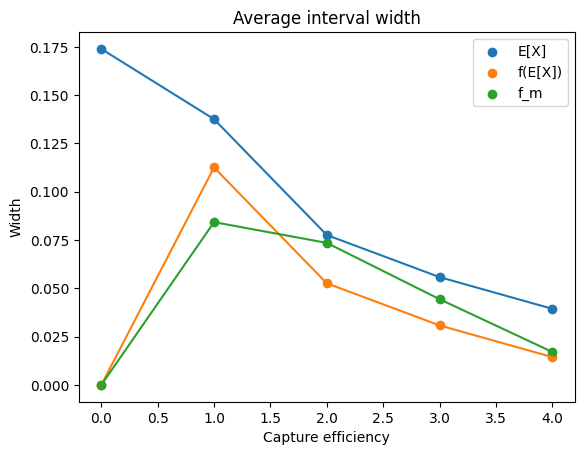

In [278]:
k = 2
dmeans = []
fmeans = []
for b in [0, 1, 5, 10, 20]:
    deltas = delta_dict[(k, b)]['deltas']
    fms = [float(x) for x in fm_dict[(k, b)] if not (x == 1)]
    
    dmeans.append(np.mean(deltas))
    fmeans.append(np.mean(fms))

adj = [x - 0.025 for x in dmeans]#[x - 3*(x**2) for x in dmeans]
adj[0] = 0

plt.plot(dmeans)
plt.scatter(range(5), dmeans, label="E[X]")
plt.plot(adj)
plt.scatter(range(5), adj, label="f(E[X])")
plt.plot(fmeans)
plt.scatter(range(5), fmeans, label="f_m")
plt.legend()
plt.title("Average interval width")
plt.xlabel("Capture efficiency")
plt.ylabel("Width")

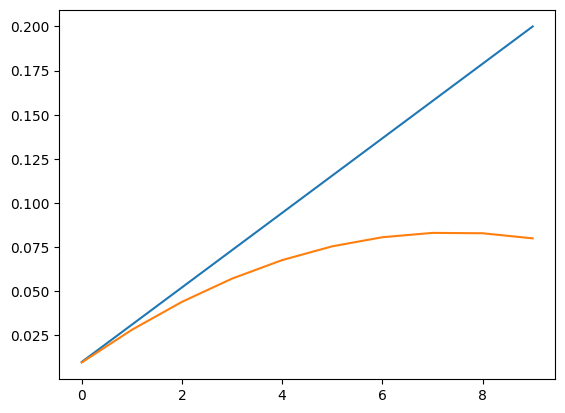

In [274]:
x = np.linspace(0.01, 0.2, 10)
plt.plot(x)
plt.plot(x - 3*(x**2))

## 1st moment vs $f_{m}$ widths

Want to input bounds about $f_{m}$ values, but see from the plot above that the average width of moment bootstrap intervals is quite different from that of the downsampled rates.

A function of $f(x) = 30 x^2$ mapping the width of the 1st moment interval to the width of the 2nd seems to map well across a range of capture efficiencies, so can use $\delta$ and $30 \delta^2$ as respective widths about true values for testing.

Also see that the range of $\delta$ seen is around $[0, 0.2]$, so focus on a range similar to this.

(NOTE: relationship differs for different parameters, choose to focus on k = 2)
